# Luke (Lupeng) Wang
## Detecting Fraud in NY Property Valuation and Assesment Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

%matplotlib inline

In [2]:
data = pd.read_csv('NY property data.csv')
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [3]:
data.shape

(1070994, 32)

# Cleaning the NY Data

## STEP 1: List of Owner Names to Remove

In [4]:
remove_list = data['OWNER'].value_counts().head(20).index.to_list()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [5]:
# remove some of these and add some others to also be removed
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append( 'CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list.append('NY STATE PUBLIC WORKS')
remove_list.append('NYC DEPT OF HIGHWAYS')
remove_list.append("NYC DEP'T OF HIGHWAYS")
remove_list.append('CITY WIDE ADMINISTRAT')
remove_list.append('DEPT OF PUBLIC WORKS')
remove_list.append( 'NEW YORK CITY')
remove_list.append('THE PORT OFNY & NJ')
remove_list.append('NYC DEPT OF PUB WORKS')
remove_list.append('NEW YORK STATE DEPART')
remove_list.append('CITY AND NON-CITY OWN')

In [6]:
property_data = data[-data['OWNER'].isin(remove_list) ].reset_index(drop=True)
property_data.shape

(1046516, 32)

In [7]:
data.shape

(1070994, 32)

In [8]:
len(data) - len(property_data)

24478

## STEP 2: Fill in the Missing ZIPs

In [9]:
property_data['ZIP'].value_counts()

10314.0    24546
11234.0    19974
10312.0    18039
10306.0    16520
11236.0    15642
           ...  
11241.0        1
11371.0        1
11005.0        1
11352.0        1
10162.0        1
Name: ZIP, Length: 195, dtype: int64

In [10]:
# How many zips are missing? replace NaN wit 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21537

In [11]:
for i in range(len(missing_zips)):
    if (property_data.loc[missing_zips[i]+1, 'ZIP']== property_data.loc[missing_zips[i]-1, 'ZIP']):
        property_data.loc[missing_zips[i], 'ZIP'] = property_data.loc[missing_zips[i]-1, 'ZIP']

In [12]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10114

In [13]:
# for the remaining missing zips, just fill in with the previous record's zip
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i], 'ZIP'] = property_data.loc[missing_zips[i]-1, 'ZIP']

In [14]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## STEP 3: Fill in Missing FULLVAL, AVLAND, AVTOT

In [15]:
property_data['FULLVAL'] = property_data['FULLVAL'].replace('NaN', 0)
temp = property_data[property_data['FULLVAL']!= 0]
mean_fullval = temp.groupby("TAXCLASS")['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     8.510005e+04
4     2.713604e+06
Name: FULLVAL, dtype: float64


In [16]:
property_data['AVLAND'] = property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [17]:
property_data['AVTOT'] = property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

In [18]:
# substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass
# %%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0) & (property_data['TAXCLASS']==index), 'FULLVAL'] = mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0) & (property_data['TAXCLASS']==index), 'AVLAND'] = mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0) & (property_data['TAXCLASS']==index), 'AVTOT'] = mean_avtot[index]

## STEP 4: Fill in Missing STORIES

In [19]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()

property_data['STORIES'] = property_data['STORIES'].fillna(value = 0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES'] == 0) & (property_data['TAXCLASS'] == index), 'STORIES'] = mean_stories[index]

In [20]:
property_data[property_data['STORIES'] == 0].shape[0]

0

## STEP 5: Fill in LTFRONT, LTDEPTH, BLDFRONT, BLDDEPTH

In [21]:
# as these 4 values do not have NAs, we need to replace 0s. 
# calculate groupwise average. First replace the 0’s and 1’s by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan

property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# calculate the mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

# impute values
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

# Calculate 90 Fraud Algorithm Variables

In [22]:
# Convert ZIP to an integer rather than a float
property_data['ZIP'] = property_data['ZIP'].astype(str)
property_data['zip3'] = property_data['ZIP'].str[:3]

property_data['ltsize'] = property_data["LTFRONT"] * property_data['LTDEPTH']
property_data['bldsize'] = property_data["BLDFRONT"] * property_data['BLDDEPTH']
property_data['bldvol'] = property_data["bldsize"] * property_data['STORIES']

property_data['r1'] = property_data['FULLVAL'] / property_data['ltsize']
property_data['r2'] = property_data['FULLVAL'] / property_data['bldsize']
property_data['r3'] = property_data['FULLVAL'] / property_data['bldvol']
property_data['r4'] = property_data['AVLAND'] / property_data['ltsize']
property_data['r5'] = property_data['AVLAND'] / property_data['bldsize']
property_data['r6'] = property_data['AVLAND'] / property_data['bldvol']
property_data['r7'] = property_data['AVTOT'] / property_data['ltsize']
property_data['r8'] = property_data['AVTOT'] / property_data['bldsize']
property_data['r9'] = property_data['AVTOT'] / property_data['bldvol']

In [23]:
property_data.columns[36:]

Index(['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9'], dtype='object')

In [24]:
for col in property_data.columns[36:]:
    property_data[col+'inv'] = 1 / (property_data[col])

In [25]:
vars18 = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
         'r1inv', 'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv', 'r9inv']
zip5_mean = property_data.groupby("ZIP")[vars18].mean()
zip3_mean = property_data.groupby("zip3")[vars18].mean()
taxclass_mean = property_data.groupby("TAXCLASS")[vars18].mean()
borough_mean = property_data.groupby("BORO")[vars18].mean()
property_data = property_data.join(zip5_mean, on = "ZIP", rsuffix = '_zip5')
property_data = property_data.join(zip3_mean, on = "zip3", rsuffix = '_zip3')
property_data = property_data.join(taxclass_mean, on = "TAXCLASS", rsuffix = '_taxclass')
property_data = property_data.join(borough_mean, on = "BORO", rsuffix = '_boro')
rsuffix = ["_zip5", "_zip3", "_taxclass", "_boro"]
for var in vars18:
    for r in rsuffix:
        property_data[str(var)+r] = property_data[var] / property_data[str(var)+r]

In [26]:
property_data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT',
       ...
       'r9_boro', 'r1inv_boro', 'r2inv_boro', 'r3inv_boro', 'r4inv_boro',
       'r5inv_boro', 'r6inv_boro', 'r7inv_boro', 'r8inv_boro', 'r9inv_boro'],
      dtype='object', length=126)

# Calculate the Basic Statistical Properties of 90 Variables

In [27]:
variables = property_data[property_data.columns[36:]]
stats = variables.describe().T
stats.head(20)

,count,mean,std,min,25%,50%,75%,max
r1,1046516.0,213.503808,528.509868,0.000392,76.375353,152.916667,243.200000,135680.195265
r2,1046516.0,536.237504,1015.743970,0.000747,212.235545,500.000000,683.891491,310742.524961
r3,1046516.0,243.931653,486.583927,0.000090,82.741261,239.102564,336.257310,227500.000000
r4,1046516.0,10.453704,69.427805,0.000008,2.356020,4.598000,7.225959,22032.314558
r5,1046516.0,22.710592,373.449262,0.000210,6.215246,14.983333,20.287152,334842.138488
r6,1046516.0,9.972084,173.490209,0.000010,2.021085,7.148054,10.043885,111614.046163
r7,1046516.0,26.785106,201.622470,0.000008,5.284000,8.581667,13.528964,63386.622397
r8,1046516.0,50.329579,930.162498,0.000306,17.478683,26.980501,36.003636,871898.008737
r9,1046516.0,18.980834,323.424616,0.000060,7.100314,12.679808,17.575758,290632.669579
r1inv,1046516.0,0.111186,5.643281,0.000007,0.004112,0.006540,0.013093,2551.009064


# Homework 3

In [28]:
save_record = property_data['RECORD']
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
property_data = property_data.drop(columns = dropcols)

# Z scaling

In [29]:
data_zs = (property_data - property_data.mean()) / property_data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r9_boro,r1inv_boro,r2inv_boro,r3inv_boro,r4inv_boro,r5inv_boro,r6inv_boro,r7inv_boro,r8inv_boro,r9inv_boro
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-4.987863e-14,-4.120539e-14,-4.213792e-15,-1.192801e-14,-1.523930e-15,6.895732e-16,-4.875373e-14,-2.857037e-15,-1.090882e-14,-5.867553e-15,...,2.007761e-15,1.238156e-15,-2.316146e-15,-6.055043e-16,-2.560382e-15,-7.841169e-15,2.958956e-15,3.110794e-16,-2.496063e-15,2.999359e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.039724e-01,-5.279251e-01,-5.013145e-01,-1.505693e-01,-6.081250e-02,-5.747917e-02,-1.328478e-01,-5.410804e-02,-5.868685e-02,-1.970110e-02,...,-6.391883e-02,-1.759386e-02,-2.268715e-02,-2.076027e-02,-1.960607e-02,-5.141268e-02,-3.403431e-02,-1.596393e-02,-4.079891e-02,-4.659194e-02
25%,-2.594624e-01,-3.189799e-01,-3.312695e-01,-1.166346e-01,-4.417025e-02,-4.582967e-02,-1.066404e-01,-3.531737e-02,-3.673350e-02,-1.897378e-02,...,-3.880826e-02,-1.673407e-02,-2.201533e-02,-2.061962e-02,-1.797203e-02,-4.841156e-02,-3.357250e-02,-1.360515e-02,-3.734491e-02,-4.505767e-02
50%,-1.146377e-01,-3.567583e-02,-9.924473e-03,-8.434234e-02,-2.069159e-02,-1.627775e-02,-9.028477e-02,-2.510215e-02,-1.948221e-02,-1.854359e-02,...,-2.062950e-02,-1.627134e-02,-2.169611e-02,-2.053040e-02,-1.682510e-02,-4.726764e-02,-3.320045e-02,-1.112325e-02,-3.550747e-02,-4.412737e-02
75%,5.618853e-02,1.453654e-01,1.897425e-01,-4.649066e-02,-6.489343e-03,4.138601e-04,-6.574734e-02,-1.540155e-02,-4.344369e-03,-1.738226e-02,...,-3.517677e-03,-1.503698e-02,-2.064109e-02,-2.021859e-02,-1.448689e-02,-4.365410e-02,-3.213827e-02,-7.947278e-03,-3.231318e-02,-4.248983e-02
max,2.563182e+02,3.053981e+02,4.670439e+02,3.171908e+02,8.965594e+02,6.432875e+02,3.142499e+02,9.373068e+02,8.985515e+02,4.520239e+02,...,8.910096e+02,6.645625e+02,7.831392e+02,8.003317e+02,9.464894e+02,1.866375e+02,1.098890e+02,9.473780e+02,5.629369e+02,4.959927e+02


# PCA

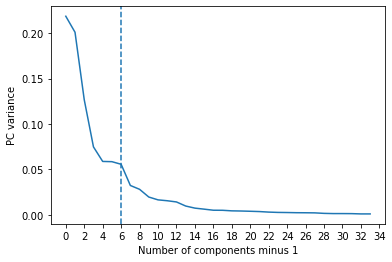

In [30]:
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=6, linestyle='--')

(0.0, 1.0)

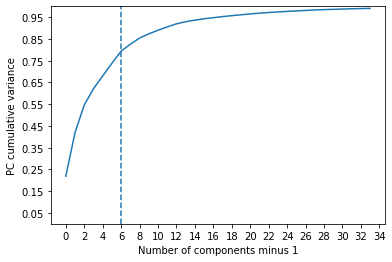

In [31]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [32]:
data_zs = data_zs_save.copy()
pca = PCA(n_components = 7, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

7

In [33]:
data_pca = pd.DataFrame(princ_comps)

In [34]:
#scaling PCA
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,0,1,2,3,4,5,6
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-7.280044e-17,-1.837720e-17,-2.624506e-16,1.063797e-17,7.144843e-18,3.353912e-16,2.164027e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.821852e+01,-8.891024e-02,-2.399561e+02,-2.940419e+02,-3.364301e+02,-2.238167e+02,-2.821592e+02
25%,-1.033812e-01,-5.119081e-02,-1.555735e-01,-2.735354e-03,-8.111186e-02,-1.327432e-01,-8.786648e-02
50%,-1.722495e-02,-4.480539e-02,-6.019241e-02,2.607797e-03,4.683933e-03,-1.151279e-02,-3.336247e-02
75%,4.002710e-02,-3.567613e-02,3.200520e-02,9.450733e-03,5.391875e-02,2.843840e-01,1.234761e-02
max,6.972967e+02,4.059682e+02,3.235610e+02,8.135371e+02,4.420073e+02,5.187210e+02,4.111819e+02


In [35]:
p1 = 2
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1

In [36]:
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation= 'logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
p2 = 2
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

/Users/Lupengwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [37]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by=['final', 'RECORD'], ascending=[False, True])

(0.1, 2088874.5789512645)

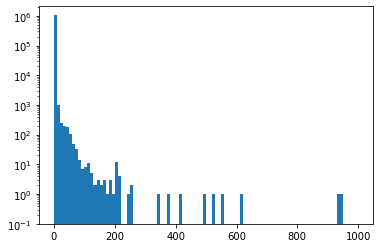

In [38]:
plt.hist(score1, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2091121.2133379462)

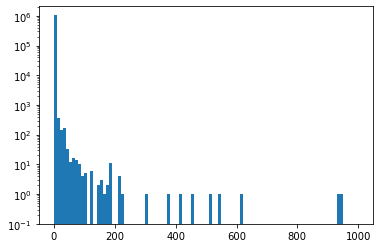

In [39]:
plt.hist(score2, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

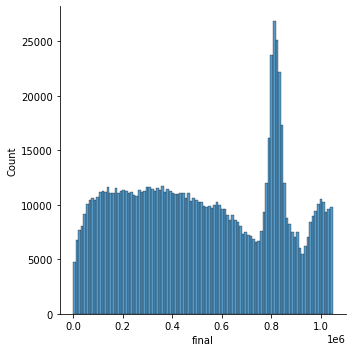

In [40]:
sns.displot(scores['final'])

In [41]:
scores_sorted

,score1,score2,RECORD,score1 rank,score2 rank,final
898718,945.415431,942.095280,917942,1046516.0,1046516.0,1046516.0
975385,932.664404,931.532301,996722,1046515.0,1046515.0,1046515.0
674960,612.794094,611.740988,691986,1046514.0,1046514.0,1046514.0
935946,553.562341,548.634559,956520,1046513.0,1046513.0,1046513.0
701584,527.014185,519.780139,718883,1046512.0,1046512.0,1046512.0
...,...,...,...,...,...,...
821269,0.049256,0.013301,839406,15.5,42.5,29.0
821270,0.049256,0.013301,839407,15.5,42.5,29.0
821271,0.049256,0.013301,839408,15.5,42.5,29.0
821256,0.049474,0.013034,839393,25.0,28.0,26.5


In [42]:
result = pd.merge(data,scores_sorted, how='right').drop(['score1', 'score2'], axis=1)

In [43]:
result_30 = result.iloc[:30, :]

In [44]:
result_30

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046516.0,1046516.0,1046516.0
1,996722,5029220125,5,2922,125,NaN,IMPERIAL COURT HOMEOW,V0,1B,300,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046515.0,1046515.0,1046515.0
2,691986,4039160200,4,3916,200,NaN,TITAN SOUNDVIEW POINT,Z7,4,0,...,3.000000e+00,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046514.0,1046514.0,1046514.0
3,956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046513.0,1046513.0,1046513.0
4,718883,4051251107,4,5125,1107,NaN,GARDEN VIEW LTD,R4,2,0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046512.0,1046512.0,1046512.0
5,459429,3059930075,3,5993,75,NaN,NaN,V0,1B,8,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046511.0,1046511.0,1046511.0
6,658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046510.0,1046510.0,1046510.0
7,649717,4025270002,4,2527,2,NaN,57-43 LLC,V1,4,51,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046509.0,1046509.0,1046509.0
8,1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046508.0,1046508.0,1046508.0
9,12076,1001790001,1,179,1,NaN,15 WORTH STREET PROPE,G6,4,74,...,9.414000e+05,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046507.0,1046507.0,1046507.0
